# Running multi-container endpoints on Amazon SageMaker

SageMaker multi-container endpoints enable customers to deploy multiple containers to deploy different models on a SageMaker endpoint. The containers can be run in a sequence as an inference pipeline, or each container can be accessed individually by using direct invocation to improve endpoint utilization and optimize costs.


This notebook shows how to create a multi-container endpoint which will host both the PyTorch(>=1.5) model and a TensorFlow(>=2.0) model, on a single endpoint. Here, `Direct` invocation behavior of multi-container endpoints is showcased where each model container can be invoked directly rather than being called in a sequence.

This notebook is divided in the following sections:

1. **Pre-requisites**
1. **Setup Multi-container Endpoint with Direct Invocation**
1. **Inference**
1. **Clean up**

## Section 1: Pre-requisites

![weigthed_routing](notebook_images/Hosting_RealTime_MultiContainer.png)

![weigthed_routing](notebook_images/Hosting_MultiContainer_TF_PyTorch.png)

First, import some necessary libraries and variables. This is the place where the output paths for the models are defined.

In [1]:
import os
import json
import time
import random
import numpy as np
from utils.mnist import mnist_to_numpy, normalize
import random
import matplotlib.pyplot as plt

import boto3
import sagemaker
from sagemaker.tensorflow import TensorFlow
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.s3 import S3Downloader
from sagemaker.s3 import S3Uploader

sess = sagemaker.Session()

role = get_execution_role()

bucket = sess.default_bucket()

output_prefix = "/multi-container-endpoint/output"
output_path = "s3://" + bucket + output_prefix

region = sess.boto_region_name

sm_client = sess.sagemaker_client
runtime_sm_client = sess.sagemaker_runtime_client
s3_client = boto3.client("s3")

Matplotlib is building the font cache; this may take a moment.


### Dataset

This notebook uses `MNIST` dataset. `MNIST` is a widely used dataset for handwritten digit classification. It consists of 70,000 labeled `28x28` pixel grayscale images of hand-written digits. The dataset is split into 60,000 training images and 10,000 test images. There are 10 classes (one for each of the 10 digits). 


## Section 4: Set up Multi-container endpoint with Direct Invocation

In this section, a multi-container endpoint is set up.

SageMaker multi-container endpoints enable customers to deploy multiple containers to deploy different models on the same SageMaker endpoint. The containers can be run in a sequence as an inference pipeline, or each container can be accessed individually by using `direct` invocation to improve endpoint utilization and optimize costs.

The TensorFlow and PyTorch models, trained in the earlier sections would be deployed against a single sagemaker endpoint using multi-container capability of SageMaker Endpoints. This section uses`boto3` APIs.

Setting up a multi-container endpoint is a multi-step process, which looks like the following:
- Create inference container definitions for all the containers needed to deploy
- Create a SageMaker model using the `create_model` API. Use the `Containers` parameter instead of `PrimaryContainer`, and include more than one container in the `Containers` parameter.
- Create a SageMaker Endpoint Configuration using the `create_endpoint_config` API
- Create a SageMaker Endpoint using the `create_endpoint` API which uses the model and endpoint configuration created in the earlier steps.



### Create inference container definition for TensorFlow model

To create a container definition, following must be defined :

- `ContainerHostname`: The value of the parameter uniquely identifies the container for the purposes of logging and metrics. The `ContainerHostname` parameter is required for each container in a multi-container endpoint with `direct` invocation. Though it can be skipped, in case of serial inference pipeline as the inference pipeline will assign a unique name automatically.

- `Image`: It is the path where inference code is stored. This can be either in Amazon EC2 Container Registry or in a Docker registry that is accessible from the same VPC that is configured for the endpoint. If custom algorithm is used instead of an algorithm provided by Amazon SageMaker, the inference code must meet Amazon SageMaker requirements.

- `ModelDataUrl`: The S3 path where the model artifacts, which result from model training, are stored. This path must point to a single GZIP compressed tar archive (`.tar.gz` suffix). The S3 path is required for Amazon SageMaker built-in algorithms/frameworks, but not if a custom algorithm (not provided by sagemaker) is used.

For the Image argument, supply the ECR path of the TensorFlow 2.3.1 inference image. For deep learning images available in SageMaker, refer to [Available Deep Learning Containers Images](https://github.com/aws/deep-learning-containers/blob/master/available_images.md).


In [2]:
### Upload TensorFlow model to S3.f

In [3]:
# upload tensorflow model.tar.gz to s3
updated_tf_model_key = "multi-container-endpoint/output/tensorflow"
tf_mnist_model_data = S3Uploader.upload(
    "model/tensorflow/model.tar.gz", "s3://{}/{}".format(bucket, updated_tf_model_key))
tf_mnist_model_data

's3://sagemaker-us-west-2-328296961357/multi-container-endpoint/output/tensorflow/model.tar.gz'

In [4]:
tf_ecr_image_uri = sagemaker.image_uris.retrieve(
    framework="tensorflow",
    region=region,
    version="2.3.1",
    py_version="py37",
    instance_type="ml.c5.4xlarge",
    image_scope="inference",
)

tensorflow_container = {
    "ContainerHostname": "tensorflow-mnist",
    "Image": tf_ecr_image_uri,
    "ModelDataUrl": tf_mnist_model_data,
}

### Create inference container definition for PyTorch model

Now similarly, create the container definition for PyTorch model. 

Here in addition to the arguments defined for TensorFlow container, one more additional argument needs to be defined which is `Environment`. This is because the PyTorch model server needs to know how to load the model and make the predictions. This is explained in detail in the following section.


To tell the inference image how to load the model checkpoint, it needs to implement:

- How to parse the incoming request
- How to use the trained model to make inference
- How to return the prediction to the caller of the service


To achieve this, it needs to:

- implement a function called `model_fn` which returns a PyTorch model.
- implement a function called `input_fn` function which handles data decoding and returns an object that can be passed to `predict_fn`
- implement a function called `predict_fn` function which will perform the prediction and returns as object that can be passed to `output_fn`
- implement a function called `output_fn` function which will perform the de-serialization of the output given by `predict_fn`


To achieve this, `inference.py` is created which provides the implementation of all the above functions in that file. This file must be supplied as an environment variable `SAGEMAKER_PROGRAM`.

The model and `inference.py` also need to be wrapped together in a single `tar.gz`. The following steps are performed to zip the inference and model file together:

- Unzip the `model.tar.gz`. The `model.pth` file is visible after unzipping.
- GZIP the `model file(.pth)` and the `inference.py` together in a new `tar.gz`
- Upload the new `tar.gz` to `s3` location, to be referred in the `model container definition` later


In [5]:
# move pytorch model to the working directory
!cp model/pytorch/pt_model.tar.gz .

# unzip the tar.gz
!tar -xvf pt_model.tar.gz

# after unzipping, remove the model.tar.gz
!rm pt_model.tar.gz

# copy the pytorch inference script to current dir
!cp pytorch/code/inference.py .

# gzip the inference.py and model file together in a new model.tar.gz
!tar -czvf model.tar.gz model.pth inference.py

# remove the residual files
!rm inference.py model.pth

# upload the new tar.gz to s3
updated_pt_model_key = "multi-container-endpoint/output/pytorch/updated"
pt_updated_model_uri = S3Uploader.upload(
    "model.tar.gz", "s3://{}/{}".format(bucket, updated_pt_model_key)
)

# remove the new model.tar.gz from the current dir
!rm model.tar.gz

pt_updated_model_uri

model.pth
model.pth
inference.py


's3://sagemaker-us-west-2-328296961357/multi-container-endpoint/output/pytorch/updated/model.tar.gz'


Now, everything is ready to create a container definition for PyTorch container


In [6]:
pt_ecr_image_uri = sagemaker.image_uris.retrieve(
    framework="pytorch",
    region=region,
    version="1.8.1",
    py_version="py36",
    instance_type="ml.c5.4xlarge",
    image_scope="inference",
)

pytorch_container = {
    "ContainerHostname": "pytorch-mnist",
    "Image": pt_ecr_image_uri,
    "ModelDataUrl": pt_updated_model_uri,
    "Environment": {
        "SAGEMAKER_PROGRAM": "inference.py",
        "SAGEMAKER_SUBMIT_DIRECTORY": pt_updated_model_uri,
    },
}

### Create a SageMaker Model

In the below cell, call the `create_model` API to create a model which contains the definitions of both the PyTorch and TensorFlow containers created above. It needs to supply both the containers under the `Containers` argument. Also set the `Mode` parameter of the `InferenceExecutionConfig` field to `Direct` for direct invocation of each container, or `Serial` to use containers as an inference pipeline. The default mode is `Serial`. For more details, check out [Deploy multi-container endpoints](https://docs.aws.amazon.com/sagemaker/latest/dg/multi-container-endpoints.html)


Since this notebook focuses on the Direct invocation behavior, hence set the value as `Direct`.


In [7]:
create_model_response = sm_client.create_model(
    ModelName="mnist-multi-container",
    Containers=[pytorch_container, tensorflow_container],
    InferenceExecutionConfig={"Mode": "Direct"},
    ExecutionRoleArn=role,
)

### Create Endpoint Configuration

Now, create an endpoint configuration by calling the `create_endpoint_config` API. Here, supply the same `ModelName` used in the `create_model` API call.

In [8]:
endpoint_config = sm_client.create_endpoint_config(
    EndpointConfigName="mnist-multi-container-ep-config",
    ProductionVariants=[
        {
            "VariantName": "prod",
            "ModelName": "mnist-multi-container",
            "InitialInstanceCount": 1,
            "InstanceType": "ml.c5.4xlarge",
        },
    ],
)

### Create a SageMaker Multi-container endpoint

Now, the last step is to create a SageMaker multi-container endpoint. The `create_endpoint` API is used for this. The API behavior has no change compared to how a single container/model endpoint is deployed.

In [9]:
endpoint = sm_client.create_endpoint(
    EndpointName="mnist-multi-container-ep", EndpointConfigName="mnist-multi-container-ep-config"
)

The `create_endpoint` API is synchronous in nature and returns an immediate response with the endpoint status being in`Creating` state. It takes around ~8-10 minutes for multi-container endpoint to be `InService`.

In the below cell, use the `describe_endpoint` API to check the status of endpoint creation. It runs a simple waiter loop calling the `describe_endpoint` API, for the endpoint to be `InService`

In [10]:
describe_endpoint = sm_client.describe_endpoint(EndpointName="mnist-multi-container-ep")

endpoint_status = describe_endpoint["EndpointStatus"]

while endpoint_status != "InService":
    print("Current endpoint status is: {}, Trying again...".format(endpoint_status))
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName="mnist-multi-container-ep")
    endpoint_status = resp["EndpointStatus"]

print("Endpoint status changed to 'InService'")

Current endpoint status is: Creating, Trying again...
Current endpoint status is: Creating, Trying again...
Current endpoint status is: Creating, Trying again...
Current endpoint status is: Creating, Trying again...
Current endpoint status is: Creating, Trying again...
Current endpoint status is: Creating, Trying again...
Current endpoint status is: Creating, Trying again...
Endpoint status changed to 'InService'


## Section 5: Inference

Now that the endpoint is set up it is time to perform inference on the endpoint by specifying one of the container host name. First, download the `MNIST` data and select a random sample of images. 

Use the helper functions defined in `code.utils` to download `MNIST` data set and normalize the input data.


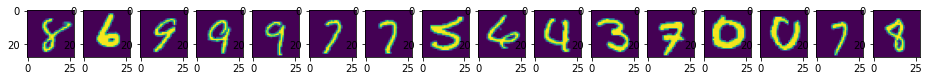

In [11]:
%matplotlib inline

data_dir = "data/"
X, _ = mnist_to_numpy(data_dir, train=False)

# randomly sample 16 images to inspect
mask = random.sample(range(X.shape[0]), 16)
samples = X[mask]

# plot the images
fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(16, 1))

for i, splt in enumerate(axs):
    splt.imshow(samples[i])

In [12]:
print(samples.shape, samples.dtype)

(16, 28, 28) uint8


### Invoking the TensorFlow container

Now invoke the TensorFlow container, on the same endpoint. First normalize the sample selected and then pass the sample to the `invoke_endpoint` API.

In [13]:
tf_samples = normalize(samples, axis=(1, 2))

tf_result = runtime_sm_client.invoke_endpoint(
    EndpointName="mnist-multi-container-ep",
    ContentType="application/json",
    Accept="application/json",
    TargetContainerHostname="tensorflow-mnist",
    Body=json.dumps({"instances": np.expand_dims(tf_samples, 3).tolist()}),
)

tf_body = tf_result["Body"].read().decode("utf-8")

tf_json_predictions = json.loads(tf_body)["predictions"]

# softmax to logit
tf_predictions = np.array(tf_json_predictions, dtype=np.float32)
tf_predictions = np.argmax(tf_json_predictions, axis=1)

In [14]:
print("Predictions: ", tf_predictions.tolist())

Predictions:  [8, 6, 9, 9, 9, 7, 7, 5, 4, 4, 3, 7, 0, 0, 7, 8]


### Invoke PyTorch container

Now, invoke the PyTorch Container. In `transform_fn`, of `inference.py` it is declared that the parsed data is a python dictionary with a key `inputs` and its value should be a 1D array of length 784. Hence, create a sample inference data in the cell below.

Before we invoke the SageMaker PyTorch model server with `samples`, we need to do some pre-processing
- convert its data type to 32 bit floating point
- normalize each channel (only one channel for `MNIST`)
- add a channel dimension

In [15]:
pt_samples = normalize(samples.astype(np.float32), axis=(1, 2))

pt_result = runtime_sm_client.invoke_endpoint(
    EndpointName="mnist-multi-container-ep",
    ContentType="application/json",
    Accept="application/json",
    TargetContainerHostname="pytorch-mnist",
    Body=json.dumps({"inputs": np.expand_dims(pt_samples, axis=1).tolist()}),
)

pt_body = pt_result["Body"].read().decode("utf-8")

pt_predictions = np.argmax(np.array(json.loads(pt_body), dtype=np.float32), axis=1).tolist()
print("Predicted digits: ", pt_predictions)

Predicted digits:  [3, 1, 1, 1, 1, 1, 4, 4, 1, 4, 4, 4, 6, 6, 3, 1]



## Section 6: clean up


Before leaving this exercise, it is a good practice to delete the resources created.

In [16]:
sm_client.delete_endpoint(EndpointName="mnist-multi-container-ep")
sm_client.delete_endpoint_config(EndpointConfigName="mnist-multi-container-ep-config")
sm_client.delete_model(ModelName="mnist-multi-container")

{'ResponseMetadata': {'RequestId': '185033b8-65e3-4473-94c9-3319b6a4783a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '185033b8-65e3-4473-94c9-3319b6a4783a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 28 Jan 2022 23:19:26 GMT'},
  'RetryAttempts': 0}}

### This is the blog that provides more description of multi-container endpoing. It leverages this Jupyter notebook
https://aws.amazon.com/blogs/machine-learning/deploy-multiple-serving-containers-on-a-single-instance-using-amazon-sagemaker-multi-container-endpoints/